In [1]:
# System libraries
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# Custom libraries
from utils.gpu_util import set_device
from utils.train_utils import get_optimizer

# Helper libraries
import tensorflow as tf
import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Set plot style
get_ipython().run_line_magic('matplotlib', 'inline')
set_device('gpu')

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.initializers import he_uniform

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Choose a dataset method of 1, 2 or 3

## 1. Load Tensorflow datasets

In [4]:
import tensorflow_datasets as tfds

In [5]:
#train, valid = tfds.load('mnist', split=['train', 'test'], as_supervised=True, batch_size=64)
[train, valid], info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, batch_size=64, with_info=True)

In [6]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

train = train.map(normalize_img)
train_ds = train.map(lambda x, y: (x, tf.one_hot(y, depth=10)))

valid = valid.map(normalize_img)
valid_ds = valid.map(lambda x, y: (x, tf.one_hot(y, depth=10)))

In [7]:
print("Dataset cardinality")
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(valid_ds).numpy())

Dataset cardinality
782
157


In [8]:
print(info.features['image'].shape)

(32, 32, 3)


In [9]:
image_size = info.features['image'].shape

## 2. tf Data

In [10]:
from glob import glob

In [11]:
data_dir = '../dataset/plants-water'

In [12]:
list_ds = tf.data.Dataset.list_files(data_dir+ '/*/*', shuffle=False)# get the count of image files in the train directory

In [13]:
list_ds = list_ds.shuffle(200, reshuffle_each_iteration=False)

In [14]:
for f in list_ds.take(5):
    print(f.numpy())

b'../dataset/plants-water/water/3Eax7IYlEyc.jpg'
b'../dataset/plants-water/plants/0kBhBH5gWWE.jpg'
b'../dataset/plants-water/plants/_583eiIT_84.jpg'
b'../dataset/plants-water/plants/0mhcdAI9qhw.jpg'
b'../dataset/plants-water/plants/0K9H0yts_tE.jpg'


In [15]:
class_names = [item.split('/')[-1:][0] for item in glob(data_dir+'/*') ]

In [16]:
class_names

['plants', 'water']

In [17]:
train_ds = list_ds.skip(30)
valid_ds = list_ds.take(30).skip(15)
test_ds = list_ds.take(15)

In [18]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(valid_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

90
15
15


In [19]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.one_hot(tf.argmax(one_hot),depth=2)

In [20]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.per_image_standardization(img)
    # resize the image to the desired size
    return img

In [21]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [22]:
train_ds = train_ds.map(process_path)
valid_ds = valid_ds.map(process_path)
test_ds = test_ds.map(process_path)

In [23]:
train_ds = train_ds.batch(10)
valid_ds = valid_ds.batch(15)
test_ds = test_ds.batch(15)

In [24]:
train_img_batch, train_label_batch = next(iter(train_ds))
valid_img_batch, valid_label_batch = next(iter(valid_ds))
test_img_batch, test_label_batch = next(iter(test_ds))

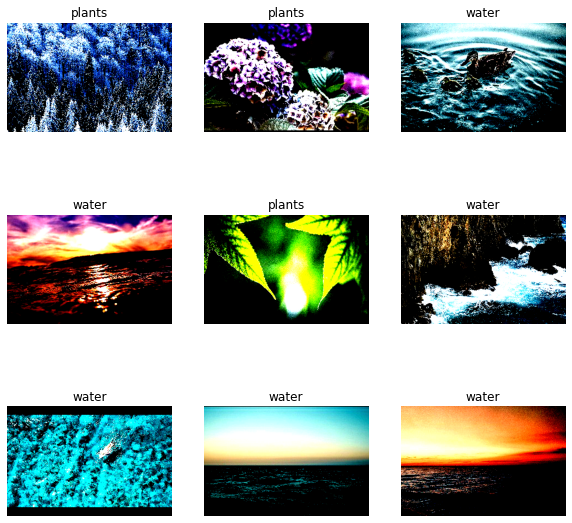

In [25]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_img_batch[i].numpy()/255)
    label = tf.argmax(train_label_batch[i])
    plt.title(class_names[label])
    plt.axis("off")

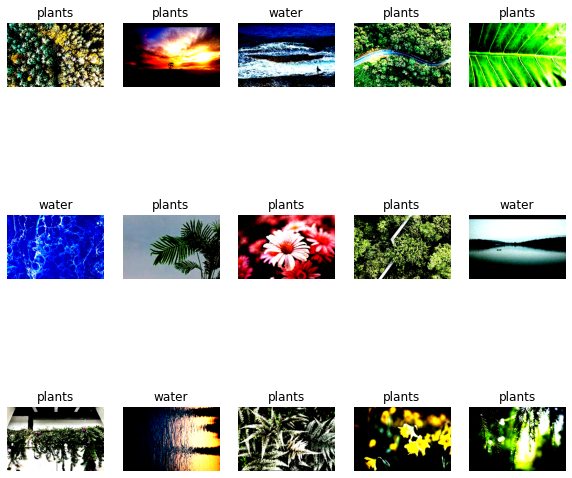

In [26]:
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(valid_img_batch[i].numpy()/255)
    label = tf.argmax(valid_label_batch[i])
    plt.title(class_names[label])
    plt.axis("off")

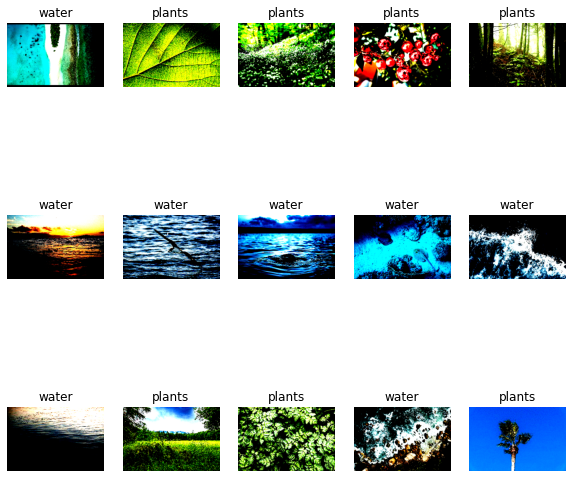

In [27]:
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(test_img_batch[i].numpy()/255)
    label = tf.argmax(test_label_batch[i])
    plt.title(class_names[label])
    plt.axis("off")

## 3. Generators

In [28]:
generator = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

In [31]:
train = generator.flow_from_directory(directory='../dataset/plants-water/', target_size=(200, 300),
                                      color_mode='rgb',classes=['plants', 'water'], batch_size=10, save_format='jpg', subset="training")
valid = generator.flow_from_directory(directory='../dataset/plants-water/', target_size=(200, 300),
                                      color_mode='rgb',classes=['plants', 'water'], batch_size=20, save_format='jpg', subset="validation")

Found 96 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


# Train Models

### TF dataset

In [10]:
def get_tfds_model(image_size):
    model = Sequential()

    model.add(Conv2D(12, (3, 3), padding='valid', strides=(1,1),
                    activation='relu',
                     input_shape=([*image_size])))

    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Conv2D(12, (3, 3), padding='valid', strides=(1,1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10, activation='softmax'))

    return model

In [14]:
optimizer = get_optimizer(0.001, 'adam')
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=[tfa.metrics.F1Score(num_classes=10, average='macro'), 'acc'])

results = model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=10,
                    verbose=2)#, callbacks=[early_stopping(), model_chpnt()])

Epoch 1/10
782/782 - 6s - loss: 1.0292 - f1_score: 0.6250 - acc: 0.6272 - val_loss: 1.1069 - val_f1_score: 0.6080 - val_acc: 0.6114
Epoch 2/10
782/782 - 6s - loss: 1.0204 - f1_score: 0.6298 - acc: 0.6322 - val_loss: 1.0911 - val_f1_score: 0.6169 - val_acc: 0.6194
Epoch 3/10
782/782 - 6s - loss: 1.0062 - f1_score: 0.6342 - acc: 0.6363 - val_loss: 1.0943 - val_f1_score: 0.6128 - val_acc: 0.6181
Epoch 4/10
782/782 - 6s - loss: 0.9910 - f1_score: 0.6403 - acc: 0.6424 - val_loss: 1.0987 - val_f1_score: 0.6127 - val_acc: 0.6168
Epoch 5/10
782/782 - 6s - loss: 0.9815 - f1_score: 0.6435 - acc: 0.6456 - val_loss: 1.1100 - val_f1_score: 0.6091 - val_acc: 0.6132
Epoch 6/10
782/782 - 6s - loss: 0.9721 - f1_score: 0.6456 - acc: 0.6473 - val_loss: 1.1087 - val_f1_score: 0.6114 - val_acc: 0.6148
Epoch 7/10
782/782 - 6s - loss: 0.9696 - f1_score: 0.6467 - acc: 0.6486 - val_loss: 1.1135 - val_f1_score: 0.6093 - val_acc: 0.6126
Epoch 8/10


KeyboardInterrupt: 

### Trees-Water

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

In [33]:
def get_trees_water_model(image_size):
    model = Sequential()

    # Input Layers
    
    #model.add(BatchNormalization(input_shape=([*image_size, 1])))
    model.add(Conv2D(12, (12, 12), padding='valid', strides=(1,1),
                    #kernel_regularizer=tf.keras.regularizers.l2(0.01),
                    activation='relu',
                    #kernel_initializer=he_uniform(),
                    #input_shape=([*image_size, 3])))
                     input_shape=([*image_size])))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(BatchNormalization())
    model.add(Conv2D(12, (12, 12), padding='valid', strides=(2,2), activation='relu'))
    #model.add(BatchNormalization())
    model.add(Conv2D(12, (12, 12), padding='valid', strides=(4,4), activation='relu'))
    model.add(Dropout(0.3))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='valid'))

    model.add(Conv2D(24, (5, 5), padding='valid', activation='relu'))
    #model.add(BatchNormalization())
    model.add(Conv2D(24, (5, 5), padding='valid', activation='relu'))
    model.add(Dropout(0.2))    
    model.add(AveragePooling2D(pool_size=(2, 2), padding='valid'))    
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation='softmax'))

    return model

In [34]:
#model = get_tfds_model(image_size)
model = get_trees_water_model([200,300,3])

In [35]:
optimizer = get_optimizer(0.0001, 'adam')
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=[tfa.metrics.F1Score(num_classes=2, average='macro'), 'acc'])

results = model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=30,
                    verbose=2)#, callbacks=[early_stopping(), model_chpnt()])

Epoch 1/30
9/9 - 1s - loss: 1.2642 - f1_score: 0.4579 - acc: 0.5222 - val_loss: 0.8361 - val_f1_score: 0.4000 - val_acc: 0.4000
Epoch 2/30
9/9 - 1s - loss: 0.7834 - f1_score: 0.4999 - acc: 0.5222 - val_loss: 0.7738 - val_f1_score: 0.3891 - val_acc: 0.4000
Epoch 3/30
9/9 - 1s - loss: 0.7264 - f1_score: 0.5249 - acc: 0.5333 - val_loss: 0.7323 - val_f1_score: 0.3891 - val_acc: 0.4000
Epoch 4/30
9/9 - 1s - loss: 0.7067 - f1_score: 0.5276 - acc: 0.5444 - val_loss: 0.7538 - val_f1_score: 0.4643 - val_acc: 0.4667
Epoch 5/30
9/9 - 1s - loss: 0.7020 - f1_score: 0.5174 - acc: 0.5222 - val_loss: 0.7203 - val_f1_score: 0.5333 - val_acc: 0.5333
Epoch 6/30
9/9 - 1s - loss: 0.6821 - f1_score: 0.5967 - acc: 0.6111 - val_loss: 0.6766 - val_f1_score: 0.5333 - val_acc: 0.5333
Epoch 7/30
9/9 - 1s - loss: 0.6380 - f1_score: 0.5801 - acc: 0.5889 - val_loss: 0.6593 - val_f1_score: 0.5982 - val_acc: 0.6000
Epoch 8/30
9/9 - 1s - loss: 0.5881 - f1_score: 0.6758 - acc: 0.6778 - val_loss: 0.6602 - val_f1_score: 0

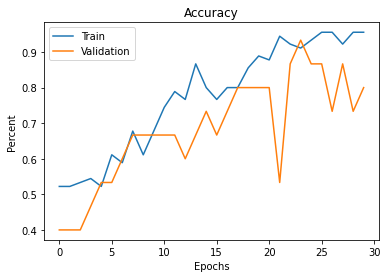

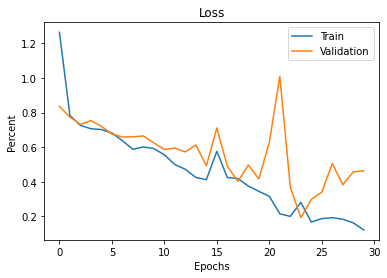

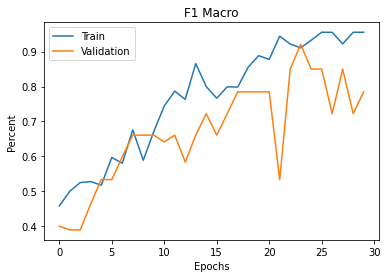

In [36]:
# Plot results in accuracy and loss metrics
plt.figure(1)
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.legend(['Train','Validation'])

plt.figure(2)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.legend(['Train','Validation'])

plt.figure(3)
plt.plot(results.history['f1_score'])
plt.plot(results.history['val_f1_score'])
plt.title('F1 Macro')
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.legend(['Train','Validation'])

In [134]:
model.save('plant-water-model',save_format='h5')

In [37]:
valid_preds = model.predict(valid_ds)

In [38]:
true_y = []
for _, y in valid_ds.take(15):
    true_y.append(np.argmax(y, axis=1))
    y = np.concatenate(true_y)

In [39]:
model.evaluate(valid_ds)

1/1 [==============================] - 0s 3ms/step - loss: 0.4634 - f1_score: 0.7847 - acc: 0.8000


[0.46343299746513367, 0.7846890091896057, 0.800000011920929]

In [40]:
cm = confusion_matrix(y, np.argmax(valid_preds, axis=1))
cm

array([[8, 3],
       [0, 4]])

#### Test set

In [41]:
eval_loss, eval_f1, eval_acc  = model.evaluate(test_ds)

1/1 [==============================] - 0s 3ms/step - loss: 1.5688 - f1_score: 0.5833 - acc: 0.6000


In [42]:
print("Model loss={:.4f}, accuracy: {:.2f}%".format(eval_loss,eval_acc * 100))

Model loss=1.5688, accuracy: 60.00%


In [43]:
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions,axis=1)

In [44]:
test_img, test_label = next(iter(test_ds))

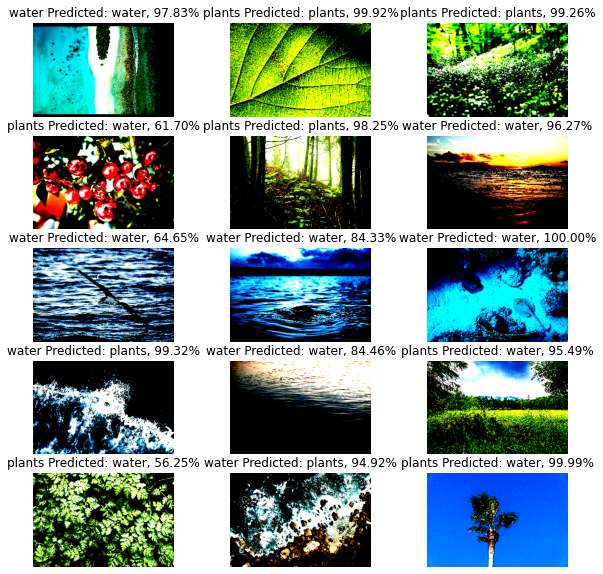

In [45]:
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(test_img[i].numpy()/255)
    
    label = np.argmax(test_label[i].numpy())

    pred_label = predicted_classes[i]    
    m = "{} Predicted: {}, {:.2f}%".format(class_names[label], class_names[pred_label], predictions[i][pred_label]*100)
    plt.title(m)
    plt.axis("off")

### Inference

In [1]:
from tensorflow.keras.models import load_model

### Load test folder and create a pipeline

In [5]:
test_dir = '../../../dataset/plant-water/test'

In [70]:
inference_ds = tf.data.Dataset.list_files(test_dir + '/*', shuffle=False)# get the count of image files in the train directory

#### Preprocess images

In [160]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img,[200,300], preserve_aspect_ratio=False)
    #img = tf.image.per_image_standardization(img)
    # resize the image to the desired size
    return img

def process_path(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, file_path

#### Load images

In [163]:
infer_images = inference_ds.map(process_path)

#### Load trained model

In [156]:
trained_model = load_model('plant-water-model.h5',compile=False)

#### Run inference 

In [235]:
inference_predicted_class = []
inference_predictions = []
results = {}
for infer_img, img_name in infer_images:
    preds = trained_model.predict(tf.expand_dims(infer_img, axis=0))
    inference_predicted_class.append(np.argmax(preds))
    inference_predictions.append(preds[0][np.argmax(preds)])
    
    results[str(img_name.numpy().decode('utf8').split('/')[-1])] = {"class":int(np.argmax(preds)), "prob":float(preds[0][np.argmax(preds)])}

In [236]:
results

{'-3LtGq_RPcY.jpg': {'class': 0, 'prob': 0.6494296193122864},
 '-3uIUqsR-Rw.jpg': {'class': 1, 'prob': 0.8624701499938965},
 '-6JK87e42iQ.jpg': {'class': 0, 'prob': 0.6562158465385437},
 '-9SsJ2jHnkg.jpg': {'class': 1, 'prob': 0.8560467958450317},
 '10IC1G_SVzE.jpg': {'class': 1, 'prob': 0.6932682991027832},
 '29SqSdfvN_A.jpg': {'class': 1, 'prob': 0.5895437002182007}}

#### Plot results

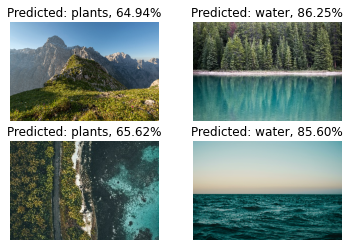

In [238]:
for i, (infer_img, img_name) in enumerate(infer_images.take(4)):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(infer_img.numpy()/255)
    
    # Find the predicted class from predictions
    m = "Predicted: {}, {:.2f}%".format(class_names[inference_predicted_class[i]], inference_predictions[i]*100)
    plt.title(m)
    plt.axis("off")

In [213]:
import json

In [237]:
json.dump(results, open("results.json","w"))

In [218]:
results

{'-3LtGq_RPcY.jpg': {'class': 0, 'prob': [0.6494296]},
 '-3uIUqsR-Rw.jpg': {'class': 1, 'prob': [0.86247015]},
 '-6JK87e42iQ.jpg': {'class': 0, 'prob': [0.65621585]},
 '-9SsJ2jHnkg.jpg': {'class': 1, 'prob': [0.8560468]},
 '10IC1G_SVzE.jpg': {'class': 1, 'prob': [0.6932683]},
 '29SqSdfvN_A.jpg': {'class': 1, 'prob': [0.5895437]}}